# Propagation Aliasing Characterization




In [1]:
import torch
import matplotlib.pyplot as plt
import scipy.io as sio

In [6]:

## simulation related
        
def image_grid(DimX, DimY, Nx, Ny):
    dX, dY = DimX/Nx, DimY/Ny
    xx = torch.linspace(-Nx / 2, Nx / 2, Ny) * dX
    yy = torch.linspace(-Ny / 2, Ny / 2, Ny) * dY
    XX, YY = torch.meshgrid(xx, yy, indexing='xy')
    return XX, YY
                        
def fourier_grid(DimX, DimY, Nx, Ny):
    # Frequency space coordinates
    fx = torch.linspace(-Nx / 2, Nx / 2, Nx) / DimX
    fy = torch.linspace(-Ny / 2, Ny / 2, Ny) / DimY
    # same as fy = torch.linspace(-0.5 / dx, 0.5 / dx, Ny)

    FX, FY = torch.meshgrid(fx, fy, indexing='xy')
    return  FX, FY
              
def propagation_kernel(FX, FY, wavelen, dz):
    Amp =  ((wavelen*FX)**2 + (wavelen*FY)**2)< 1
    
    root_arg =  1 - torch.clamp((FX*wavelen)**2 + (FY*wavelen)**2, min=0.0)
    prop_op = Amp*torch.exp(1j * (2*torch.pi/wavelen) * dz * torch.sqrt(root_arg))
                           
#     root_arg = (1/wavelen**2 - torch.clamp((FX)**2 + (FY)**2, min=0.0))
#     prop_op = Amp*torch.exp(1j * (2*torch.pi) * dz * torch.sqrt(root_arg)))
    
    return prop_op
    
def FT(inputfield):
    input_fft = torch.fft.fftshift(torch.fft.fft2(inputfield))
    return input_fft

def IFT(inputfield):
    input_ifft = torch.fft.ifft2(torch.fft.ifftshift(inputfield))
    return input_ifft

## incident wave

def sphericalwave(XX,YY, xalpha, ybeta, WD, isSphericSource, wavelen):
    xa = -torch.tensor(xalpha)
    yb = -torch.tensor(ybeta)    
    k = 2 * torch.pi / wavelen 
    xs = WD * torch.tan(xa)
    ys = WD * torch.tan(yb)
    zs = WD
    pS = torch.tensor([xs,ys,zs])
    if isSphericSource==True:
        pS = (pS)/torch.norm(pS)*WD
    dist = torch.norm(pS)    
    R_ = torch.sqrt((XX-pS[0])**2 + (YY-pS[1])**2 + pS[2]**2) + 1e-12
    Amp =  (1 / R_)
    phase = k * R_
    outputfield = Amp*torch.exp(1j * phase)
    return outputfield

def planewave(XX,YY, xalpha, ybeta, wavelen):
    xa = torch.tensor(xalpha)
    yb = torch.tensor(ybeta)    
    k = 2 * torch.pi / wavelen    
    kx = k * torch.sin(xa)
    ky = k * torch.sin(yb)    
    Amp = torch.ones_like(XX)
    phase = k * (torch.sin(xa) * XX + torch.sin(yb) * YY)
    outputfield = Amp*torch.exp(1j * phase)    
    return outputfield

## optical components

def spherical_lens(XX,YY, Aperture, wavelen, fLens):
    z_source = fLens
    R_ = torch.sqrt((XX)**2 + (YY)**2 + z_source**2)
    Amp =  ((XX- x_source)**2 + (YY - y_source)**2 )< (Aperture/2)**2
    outputfield = Amp*torch.exp(-1j * 2*torch.pi/wavelen * R_)
    return outputfield


## for convenience

def center_crop_or_pad(M_img, target_size=None, this_size=None):
    """
    Crops or zero-pads the input image `M_img` to match the target size, accounting for odd dimensions.

    Args:
        M_img (4D tensor): Input image to crop or pad (Batch, Channel, Height, Width).
        target_size (tuple): The target size (height, width) for the output tensor.
        this_size (tuple, optional): The current size of the image (height, width). 
                                     If None, it will automatically use the size of M_img.
    
    Returns:
        result_img (4D tensor): The cropped or padded image with the target size.
    """
    if this_size is None:
        this_size = M_img.shape[-2:]  # Automatically set this_size from input image dimensions (Height, Width)

    if target_size is None:
        raise ValueError("target_size must be provided.")

    # Check if we need to crop or pad
    if this_size[0] >= target_size[0] and this_size[1] >= target_size[1]:
        # Center crop the image
        top = (this_size[0] - target_size[0]) // 2
        bottom = top + target_size[0]
        left = (this_size[1] - target_size[1]) // 2
        right = left + target_size[1]
        result_img = M_img[..., top:bottom, left:right]
    
    else:
        # Zero pad the image
        v_pad_up = max((target_size[0] - this_size[0]) // 2, 0)
        v_pad_down = (target_size[0] - this_size[0]) - v_pad_up
        h_pad_left = max((target_size[1] - this_size[1]) // 2, 0)
        h_pad_right = (target_size[1] - this_size[1]) - h_pad_left

        padding = [h_pad_left, h_pad_right, v_pad_up, v_pad_down]  # Left, right, top, bottom padding
        result_img = torch.nn.functional.pad(M_img, padding, mode='constant', value=0)

    return result_img

torch.Size([4300, 4300])


/tmp/ipykernel_2742434/4245588238.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xa = -torch.tensor(xalpha)


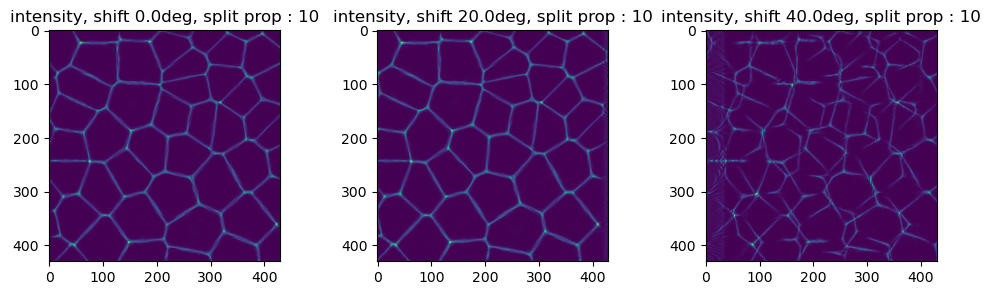

In [26]:
cm = 10**-2
mm = 10**-3
um = 10**-6


# Phase Mask
mat_contents = sio.loadmat("reference_mask.mat")
mask = torch.tensor(mat_contents['mask_flip'])
psf = torch.tensor(mat_contents['psf_flip'])

ogSize = 430
padFactor = 10

mask = center_crop_or_pad(mask, target_size = [ogSize,ogSize])
mask = center_crop_or_pad(mask, target_size = [ogSize*padFactor,ogSize*padFactor])
print(mask.shape)
[Nx, Ny] = mask.shape
dmdPxSize = (2.7*um)
DimX, DimY = Nx*dmdPxSize, Ny*dmdPxSize

# Optical system related parameters

# Nx, Ny = 1024, 1024
# DimX, DimY = 1 * mm, 1 * mm
WD = 200 * mm  # Working Distance
fLens = 1.2 * mm  # Focal length of the lens/mask, target propagation distance
dz = fLens*0.1 #propagation step
isSphericSource=True # 

# Max incident angle
XDeg = 40
numIter = 3

# wave related parameters
n0 = 1.0
nMat = 1.55
wavelen = 0.5 * um

#generate field and grids
XX,YY = image_grid(DimX,DimY,Nx,Ny)
FX,FY = fourier_grid(DimX,DimY,Nx,Ny)

#Lens
# sLens = spherical_lens(XX,YY, DimX, wavelen, fLens)
# imagesc(torch.angle(sLens), title='fLens phase')

# mask to phase
phase = mask* 2*torch.pi/wavelen * (nMat-n0)
sMask = torch.exp(1j*phase)

resultHolder = torch.zeros(numIter,ogSize,ogSize)

fig, axs = plt.subplots(1, numIter, figsize=(12,numIter))
for ind, dx in enumerate(torch.linspace(0,XDeg,numIter)):

    incidentfield = sphericalwave(XX,YY, dx*(torch.pi/180), 0, WD, isSphericSource, wavelen)
    #incidentfield = planewave(XX,YY, dx*(torch.pi/180), 0, wavelen)

    # imagesc(torch.angle(incidentfield), title='incidentfield phase')
    # imagesc(torch.abs(incidentfield), title='incidentfield ammp')

    propOp = propagation_kernel(FX, FY, wavelen, dz)
    # imagesc(torch.angle(propOp), title='propOp phase')

    iterfield = incidentfield*sMask 
    # imagesc(torch.angle(iterfield), title='iterfield phase')

    for indZ in range(round(fLens/dz)):
        fp = FT(iterfield)
        iterfield = IFT(fp*propOp)

    result = iterfield
    intensity = torch.abs(result)**2
    intensity = torch.clamp(intensity, 0, torch.max(intensity)*0.9)
    intensity = center_crop_or_pad(intensity, target_size = [ogSize,ogSize])
    resultHolder[ind,:,:] = intensity
    axs[ind].imshow(intensity)
    axs[ind].set_title(f'intensity, shift {dx:.1f}deg, split prop : {round(fLens/dz)}')
    
    # imagesc(intensity, title=f'intensity, shift {dx}deg, split prop : {round(fLens/dz)}')
    # imagesc(torch.log(intensity), title=f'Log(intensity), shift {dx}deg, split prop : {round(fLens/dz)}')
